![Syschith](syschith.png)

Copyright 2019 The TensorFlow Authors.

### Tensorflow Hub and Transfer Learning.

In this tutorial we will be utilizing the Tensorflow Hub which consists of pre-trained models. We will use one of these pre-trained models, the MobileNet to Classify our Dogs and Cats datasets. This Transfer Learning method (Using a pre-trained model to classify our datasets) will give very good accuracies as they were trained on huge datasets and they have many parameters.

http://tensorflow.org/hub

TensorFlow Hub is an online repository of already trained TensorFlow models that you can use. These models can either be used as is, or they can be used for Transfer Learning.

Transfer learning is a process where you take an existing trained model, and extend it to do additional work. This involves leaving the bulk of the model unchanged, while adding and retraining the final layers, in order to get a different set of possible outputs.

In this Colab we will do both.

Here, you can see all the models available in TensorFlow Module Hub.
https://tfhub.dev/

Concepts that will be covered in this Colab
Use a TensorFlow Hub model for prediction.
Use a TensorFlow Hub model for Dogs vs. Cats dataset.
Do simple transfer learning with TensorFlow Hub.

### Importing Libraries

In [15]:
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

# special imports
import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

In [11]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

### Part 1: Use a TensorFlow Hub MobileNet for prediction

In this part of the Colab, we'll take a trained model, load it into to Keras, and try it out.

The model that we'll use is MobileNet v2 (but any model from [tf2 compatible image classifier URL from tfhub.dev](https://tfhub.dev/s?q=tf2&module-type=image-classification) would work).

### Download the classifier
Download the MobileNet model and create a Keras model from it. MobileNet is expecting images of 224  ×  224 pixels, in 3 color channels (RGB).

In [12]:
# https://tfhub.dev/google/imagenet/mobilenet_v1_100_224/classification/4
CLASSIFIER_URL = 'https://tfhub.dev/google/imagenet/mobilenet_v1_100_224/classification/4'

In [13]:
IMAGE_RES = 224

In [16]:
model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v1_100_224/classification/4")
])

[22/Nov/2020 21:26:06] INFO - Using /var/folders/ty/0lsg06d17nn6wk41ygp7dytsbr2g5w/T/tfhub_modules to cache modules.
[22/Nov/2020 21:26:06] INFO - Downloading TF-Hub Module 'https://tfhub.dev/google/imagenet/mobilenet_v1_100_224/classification/4'.
[22/Nov/2020 21:26:25] INFO - Downloading https://tfhub.dev/google/imagenet/mobilenet_v1_100_224/classification/4: 10.67MB
[22/Nov/2020 21:26:31] INFO - Downloaded https://tfhub.dev/google/imagenet/mobilenet_v1_100_224/classification/4, Total size: 16.92MB
[22/Nov/2020 21:26:31] INFO - Downloaded TF-Hub Module 'https://tfhub.dev/google/imagenet/mobilenet_v1_100_224/classification/4'.


### Run it on a single image

MobileNet has been trained on the ImageNet dataset. ImageNet has 1000 different output classes, and one of them is military uniforms. Let's get an image containing a military uniform that is not part of ImageNet, and see if our model can predict that it is a military uniform.

65536/61306 [================================] - 1s 9us/step


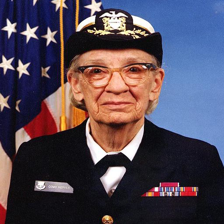

In [17]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize((IMAGE_RES, IMAGE_RES))
grace_hopper 

In [18]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [32]:
# Testing
#gh = grace_hopper

In [33]:
# Testing only
# plt.imshow(gh[ : , : , :])
# plt.show()

Remember, models always want a batch of images to process. So here, we add a batch dimension, and pass the image to the model for prediction.

In [34]:
result = model.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

The result is a 1001 element vector of logits, rating the probability of each class for the image.

So the top class ID can be found with argmax. But how can we know what class this actually is and in particular if that class ID in the ImageNet dataset denotes a military uniform or something else?

In [35]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

Decode the predictions

To see what our predicted_class is in the ImageNet dataset, download the ImageNet labels and fetch the row that the model predicted.

16384/10484 [==============================================] - 0s 1us/step


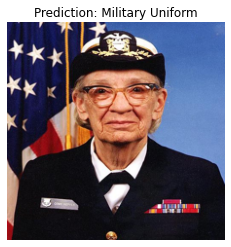

In [36]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

Worked!!!

### Part 2: Use a TensorFlow Hub models for the Cats vs. Dogs dataset

Now we'll use the full MobileNet model and see how it can perform on the Dogs vs. Cats dataset.

### Dataset
We can use TensorFlow Datasets to load the Dogs vs Cats dataset.

In [37]:
(train_examples, validation_examples), info = tfds.load(
    'cats_vs_dogs', 
    with_info=True, 
    as_supervised=True, 
    split=['train[:80%]', 'train[80%:]'],
)

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

[22/Nov/2020 21:42:11] INFO - Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: cats_vs_dogs/4.0.0
[22/Nov/2020 21:42:14] INFO - Load dataset info from /var/folders/ty/0lsg06d17nn6wk41ygp7dytsbr2g5w/T/tmp6al0dyxctfds
[22/Nov/2020 21:42:14] INFO - Field info.description from disk and from code do not match. Keeping the one from code.
[22/Nov/2020 21:42:14] INFO - Field info.citation from disk and from code do not match. Keeping the one from code.
[22/Nov/2020 21:42:14] INFO - Generating dataset cats_vs_dogs (/Users/z003z7n/tensorflow_datasets/cats_vs_dogs/4.0.0)


[22/Nov/2020 21:42:17] INFO - Downloading https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip into /Users/z003z7n/tensorflow_datasets/downloads/down.micr.com_down_3_E_1_3E1C-ECDB-4869-83i_DinAgbMqf3FriQRk8-ohFu-6RUpa3GTWGIVxvE2bA.zip.tmp.3b8ee226affb4e709f4371fdd38a6b0a...






[22/Nov/2020 21:52:53] WARNING - 1738 images were corrupted and were skipped
Shuffling and writing examples to /Users/z003z7n/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteMWWGH8/cats_vs_dogs-train.tfrecord


[22/Nov/2020 21:52:55] INFO - Done writing /Users/z003z7n/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteMWWGH8/cats_vs_dogs-train.tfrecord. Shard lengths: [2908, 2908, 2907, 2908, 2908, 2907, 2908, 2908]
[22/Nov/2020 21:52:55] INFO - Skipping computing stats for mode ComputeStatsMode.SKIP.
Dataset cats_vs_dogs downloaded and prepared to /Users/z003z7n/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.
[22/Nov/2020 21:52:55] INFO - Constructing tf.data.Dataset for split ['train[:80%]', 'train[80%:]'], from /Users/z003z7n/tensorflow_datasets/cats_vs_dogs/4.0.0


The images in the Dogs vs. Cats dataset are not all the same size.

In [38]:
for i, example_image in enumerate(train_examples.take(3)):
  print("Image {} shape: {}".format(i+1, example_image[0].shape))

Image 1 shape: (262, 350, 3)
Image 2 shape: (409, 336, 3)
Image 3 shape: (493, 500, 3)


So we need to reformat all images to the resolution expected by MobileNet (224, 224).

The .repeat() and steps_per_epoch here is not required, but saves ~15s per epoch, since the shuffle-buffer only has to cold-start once.

In [39]:
def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches      = train_examples.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

### Run the classifier on a batch of images

Remember our model object is still the full MobileNet model trained on ImageNet, so it has 1000 possible output classes. ImageNet has a lot of dogs and cats in it, so let's see if it can predict the images in our Dogs vs. Cats dataset.

In [40]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

result_batch = model.predict(image_batch)

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['tabby', 'Pembroke', 'tabby', 'tabby', 'Labrador retriever',
       'tabby', 'Border collie', 'Egyptian cat', 'tabby',
       'German shepherd', 'Australian terrier', 'basenji',
       'Labrador retriever', 'Rhodesian ridgeback', 'tiger cat',
       'Irish terrier', 'French bulldog', 'Pekinese', 'tabby', 'tabby',
       'tiger cat', 'kelpie', 'tabby', 'tabby', 'Pomeranian',
       'giant schnauzer', 'Boston bull', 'Newfoundland', 'kelpie',
       'German shepherd', 'groenendael', 'Persian cat'], dtype='<U30')

The labels seem to match names of Dogs and Cats. Let's now plot the images from our Dogs vs Cats dataset and put the ImageNet labels next to them.

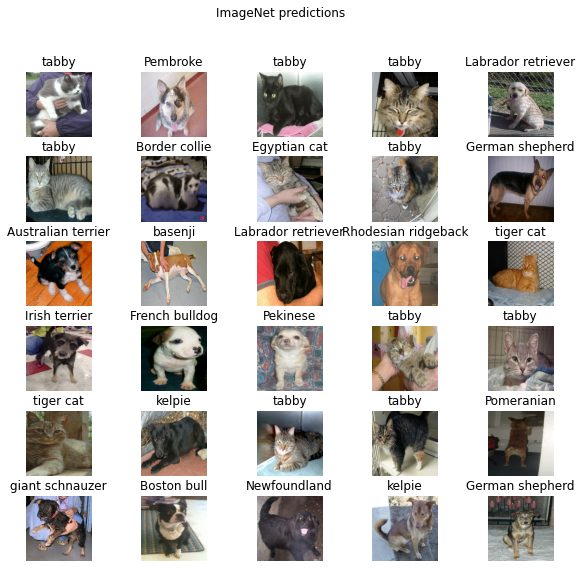

In [41]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

### Part 3: Do simple transfer learning with TensorFlow Hub
Let's now use TensorFlow Hub to do Transfer Learning.

With transfer learning we reuse parts of an already trained model and change the final layer, or several layers, of the model, and then retrain those layers on our own dataset.

In addition to complete models, TensorFlow Hub also distributes models without the last classification layer. These can be used to easily do transfer learning. We will continue using MobileNet v2 because in later parts of this course, we will take this model and deploy it on a mobile device using TensorFlow Lite. Any image feature vector URL from tfhub.dev would work here.

We'll also continue to use the Dogs vs Cats dataset, so we will be able to compare the performance of this model against the ones we created from scratch earlier.

Note that we're calling the partial model from TensorFlow Hub (without the final classification layer) a feature_extractor. The reasoning for this term is that it will take the input all the way to a layer containing a number of features. So it has done the bulk of the work in identifying the content of an image, except for creating the final probability distribution. That is, it has extracted the features of the image.

In [42]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))

[22/Nov/2020 23:08:37] INFO - Downloading TF-Hub Module 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2'.
[22/Nov/2020 23:08:48] INFO - Downloaded https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2, Total size: 9.67MB
[22/Nov/2020 23:08:48] INFO - Downloaded TF-Hub Module 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2'.


Let's run a batch of images through this, and see the final shape. 32 is the number of images, and 1280 is the number of neurons in the last layer of the partial model from TensorFlow Hub.

In [43]:
feature_batch = feature_extractor(image_batch)
print(feature_batch.shape)

(32, 1280)


Freeze the variables in the feature extractor layer, so that the training only modifies the final classifier layer.

In [44]:
feature_extractor.trainable = False

### Attach a classification head
Now wrap the hub layer in a tf.keras.Sequential model, and add a new classification layer.

In [45]:
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(2)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


Train the model
We now train this model like any other, by first calling compile followed by fit.

In [46]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 6
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
582/582 [==============================] - 417s 717ms/step - loss: 0.0619 - accuracy: 0.9766 - val_loss: 0.0350 - val_accuracy: 0.9865
Epoch 2/6
582/582 [==============================] - 410s 704ms/step - loss: 0.0306 - accuracy: 0.9896 - val_loss: 0.0319 - val_accuracy: 0.9890
Epoch 3/6
582/582 [==============================] - 418s 718ms/step - loss: 0.0263 - accuracy: 0.9909 - val_loss: 0.0327 - val_accuracy: 0.9893
Epoch 4/6
582/582 [==============================] - 419s 719ms/step - loss: 0.0218 - accuracy: 0.9926 - val_loss: 0.0325 - val_accuracy: 0.9893
Epoch 5/6
582/582 [==============================] - 419s 720ms/step - loss: 0.0205 - accuracy: 0.9934 - val_loss: 0.0326 - val_accuracy: 0.9903
Epoch 6/6
582/582 [==============================] - 31775s 55s/step - loss: 0.0176 - accuracy: 0.9944 - val_loss: 0.0322 - val_accuracy: 0.9890


You can see we get ~97% validation accuracy, which is absolutely awesome. This is a huge improvement over the model we created in the previous lesson, where we were able to get ~83% accuracy. The reason for this difference is that MobileNet was carefully designed over a long time by experts, then trained on a massive dataset (ImageNet).

Although not equivalent to TensorFlow Hub, you can check out how to create MobileNet in Keras [here](https://github.com/keras-team/keras-applications/blob/master/keras_applications/mobilenet.py).

Let's plot the training and validation accuracy/loss graphs.

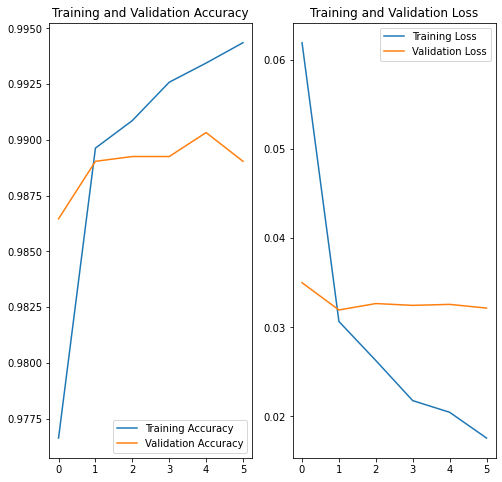

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

What is a bit curious here is that validation performance is better than training performance, right from the start to the end of execution.

One reason for this is that validation performance is measured at the end of the epoch, but training performance is the average values across the epoch.

The bigger reason though is that we're reusing a large part of MobileNet which is already trained on Dogs and Cats images. While doing training, the network is still performing image augmentation on the training images, but not on the validation dataset. This means the training images may be harder to classify compared to the normal images in the validation dataset.

### Check the predictions
To redo the plot from before, first get the ordered list of class names.

In [48]:
class_names = np.array(info.features['label'].names)
class_names

array(['cat', 'dog'], dtype='<U3')

Run the image batch through the model and convert the indices to class names.

In [49]:
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

array(['cat', 'dog', 'cat', 'cat', 'dog', 'cat', 'cat', 'cat', 'cat',
       'dog', 'dog', 'dog', 'dog', 'dog', 'cat', 'dog', 'dog', 'dog',
       'cat', 'cat', 'cat', 'dog', 'cat', 'cat', 'dog', 'dog', 'dog',
       'dog', 'dog', 'dog', 'cat', 'cat'], dtype='<U3')

Let's look at the true labels and predicted ones.

In [50]:
print("Labels: ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:  [0 1 0 0 1 0 0 0 0 1 1 1 1 1 0 1 1 1 0 0 0 1 0 0 1 1 1 1 1 1 0 0]
Predicted labels:  [0 1 0 0 1 0 0 0 0 1 1 1 1 1 0 1 1 1 0 0 0 1 0 0 1 1 1 1 1 1 0 0]


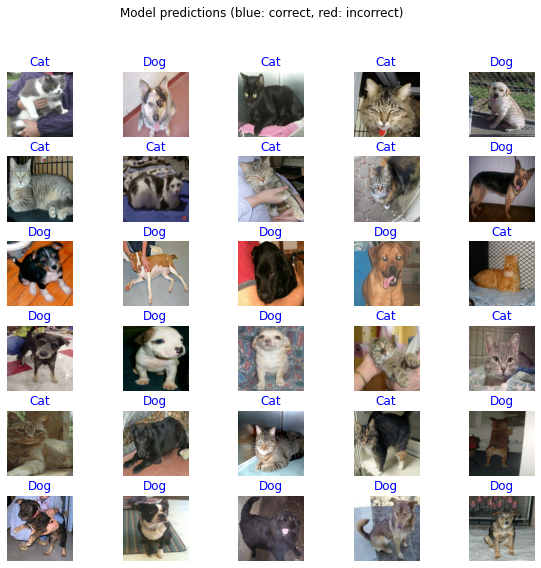

In [51]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

### Wowie!!!